# Towards fc ladder 

Architecture and formulas of layers as described in https://arxiv.org/abs/1511.06430.
We start with an external mnist dataset and do first a fc ladder. To be consistent with downloaded python ladder code (https://github.com/rinuboney/ladder/blob/master/ladder.py) we first scale the input between 0 and 1.

Try to introduce batch norm as proposed by Martin Görner following his ipynb-notebook:
https://github.com/martin-gorner/tensorflow-mnist-tutorial/blob/master/mnist_4.1_batchnorm_five_layers_relu.py

There is need for special data and mini-batch preparation for *true semi-supervised* learning with mini-batches consisting out of labeled and unlableled data.


## Here we use ladder code only to compare to purly supervised benchmark !! Therefor we set noise sd_noise=0 and loss_both = loss_supervised

In [1]:
'''
# used docker command on cluster (possilbly data in Oliver’s data directory):

nvidia-docker run -it -p 8710:8888 -p 8711:6006 -v /cluster/home/sick/:/notebooks/local -v /cluster/data/dueo/:/data -it oduerr/tf_docker:tf1_gpu_py3
'''

'''
# if working on laptop on local docker:
docker run -p 4242:8888 -v ~/dl_cas/:/notebooks -p 6006:6006 -it oduerr/tf_docker:tf1_py3
'''

'\n# if working on laptop on local docker:\ndocker run -p 4242:8888 -v ~/dl_cas/:/notebooks -p 6006:6006 -it oduerr/tf_docker:tf1_py3\n'

## Imports

In [2]:
# python module imports needed in customized functions:
import numpy as np
import tensorflow as tf
import sys

# import customized functions collected in my_fct_for_fc_ladder.py
from my_fct_for_fc_ladder_Lilach_vb import convertToOneHot
from my_fct_for_fc_ladder_Lilach_vb import my_norm
from my_fct_for_fc_ladder_Lilach_vb import my_fc_bn
from my_fct_for_fc_ladder_Lilach_vb import my_noise
from my_fct_for_fc_ladder_Lilach_vb import my_comb_vanilla
from my_fct_for_fc_ladder_Lilach_vb import encoder_prop
from my_fct_for_fc_ladder_Lilach_vb import decoder_prop
#from my_fct_for_fc_ladder_Lilach_vb import init_weights
from my_fct_for_fc_ladder_Lilach_vb import init_weights_v2
#from my_fct_for_fc_ladder_Lilach import init_weights_combiner_vanilla
#from my_fct_for_fc_ladder_Lilach import reconst_loss

#from my_fct_for_fc_ladder_Lilach_debug import decoder_prop_ver ## for debugging

In [3]:
# additional imports of python modules

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
import pandas as pd
#tf.set_random_seed(1)
#np.random.seed(1)
import sys
tf.__version__, sys.version_info



('1.0.0',
 sys.version_info(major=3, minor=4, micro=3, releaselevel='final', serial=0))

# Edit Functions

In [4]:
#############################################
# loss unsupervised per layer  - general fcn reconst_loss(encoder_clean, decoder, scope):
# formula (18): normalize dedcoder using *encoder’s* sample mean and standard deviation statistics
# input: encoder_clean, decoder (same shape than encoder_clean), scope
# output: loss_reconst (squared Euclidean distance between clean encoder layer and corresponding decoder layer)
###################################################
def reconst_loss(encoder_clean, decoder, scope):
    with tf.name_scope("squared_dist"):
        # normalize decoder using *encoder’s* sample mean and variance
        mean, variance = tf.nn.moments(encoder_clean, axes=[0])
        #mean, variance = tf.nn.moments(decoder, axes=[0])
        m = mean
        v = variance
        bnepsilon = 1e-5 #A small float number to avoid dividing by 0
        decoder_norm2 = tf.divide(tf.subtract(decoder, m),tf.sqrt(tf.add(v,bnepsilon)))
        loss_reconst = tf.reduce_mean(tf.pow(encoder_clean - decoder_norm2, 2))
        return loss_reconst

'''
## TEST 1: arbitrary inputs
# construct the graph:
tf.reset_default_graph()
# define input dimension
n1 = 2 # batch size: # images in mini-batch
n2 = 5 # layer size
inp1 = tf.placeholder(tf.float32, shape=[n1, n2], name='input')
inp2 = tf.placeholder(tf.float32, shape=[n1, n2], name='input')
# symbolic call to function
loss_rec= reconst_loss(inp1, inp2, "test")

init_op = tf.global_variables_initializer() 

# define input tensors (encoder & decoder)
in_enc = np.ones((n1,n2))
in_dec = np.arange(n1*n2).reshape((n1,n2))/n1/n2

# run the graph
sess = tf.Session()
sess.run(init_op) #initialization on the concrete realization of the graph

lres = sess.run([loss_rec],feed_dict={inp1:in_enc, inp2:in_dec}) #Evaluation result from fct my_combiner_w

print("the tf result is:")
print("loss=",lres)
# calculate with np
enc = in_enc
dec = in_dec
bneps = 1e-5
normnp = (dec-np.mean(enc,axis=0))/np.sqrt(np.var(enc,axis=0)+bneps)
sqnp = np.power((enc-normnp),2)
lossnp = np.mean(sqnp)
print("====================")
print("the np result is:")
print("enc=",enc)
print("mean enc=",np.mean(enc,axis=0))
print("var enc=",np.var(enc,axis=0))
print("dec=",dec)
print("mean dec=",np.mean(dec,axis=0))
print("var dec=",np.var(dec,axis=0))
print("loss=",lossnp)
print("normalized decoder = ",normnp)

sess.close()
'''


'\n## TEST 1: arbitrary inputs\n# construct the graph:\ntf.reset_default_graph()\n# define input dimension\nn1 = 2 # batch size: # images in mini-batch\nn2 = 5 # layer size\ninp1 = tf.placeholder(tf.float32, shape=[n1, n2], name=\'input\')\ninp2 = tf.placeholder(tf.float32, shape=[n1, n2], name=\'input\')\n# symbolic call to function\nloss_rec= reconst_loss(inp1, inp2, "test")\n\ninit_op = tf.global_variables_initializer() \n\n# define input tensors (encoder & decoder)\nin_enc = np.ones((n1,n2))\nin_dec = np.arange(n1*n2).reshape((n1,n2))/n1/n2\n\n# run the graph\nsess = tf.Session()\nsess.run(init_op) #initialization on the concrete realization of the graph\n\nlres = sess.run([loss_rec],feed_dict={inp1:in_enc, inp2:in_dec}) #Evaluation result from fct my_combiner_w\n\nprint("the tf result is:")\nprint("loss=",lres)\n# calculate with np\nenc = in_enc\ndec = in_dec\nbneps = 1e-5\nnormnp = (dec-np.mean(enc,axis=0))/np.sqrt(np.var(enc,axis=0)+bneps)\nsqnp = np.power((enc-normnp),2)\nlossn

In [5]:
def init_weights_combiner_vanilla(n2, scope,verbose):
    with tf.variable_scope(scope) as v_scope:
        # define auxiliary tensors for convenience
        ze1 = tf.zeros(n2)
        on1 = tf.ones(n2)  # used for lateral weight intitializing
        ze = tf.zeros([n2,1])
        on = tf.ones([n2,1])

        # construct weight matrices by concatinating one-dimensional 0- and 1-tensors
        # W0 for the first combiner-part (in front of sigmoid)
        W0init = tf.concat([ze, on, ze, ze], 1) ##[bias, z_lat ,u_ver, zu]
        # W1 for the inner of sigmoid providing the 2. combiner-part
        W1init = tf.concat([ze,on,ze,ze],1)

        # define weight matirces as initialized variables
        # NOTE: HERE I HAVE CORRECTED A MISTAKE 
        # make sure to define is as a 1 dim tensor such that the tf.multiply works later on
        wsig_ =  tf.Variable(on1, name = 'wsig_')
        W0_ = tf.Variable(W0init, name = 'W0_')
        W1_ = tf.Variable(W1init, name = 'W1_')
        
        # use the function tf.slice to extract the columns of the weight matrices W0_and W1_
        # so that we can follow the weight development for debugging
        # note: assign names under the given scope
        # size=[4,1] indicates that we extract 4 rows witin one col starting from begin-pos
        W0b_ = tf.slice(W0_,begin=[0,0],size=[4,1],name= 'W0b_')
        W0z_ = tf.slice(W0_,begin=[0,1],size=[4,1],name= 'W0z_')
        W0u_ = tf.slice(W0_,begin=[0,2],size=[4,1],name= 'W0u_')
        W0zu_ = tf.slice(W0_,begin=[0,3],size=[4,1],name= 'W0zu_')
        
        W1b_ = tf.slice(W1_,begin=[0,0],size=[4,1],name= 'W1b_')
        W1z_ = tf.slice(W1_,begin=[0,1],size=[4,1],name= 'W1z_')
        W1u_ = tf.slice(W1_,begin=[0,2],size=[4,1],name= 'W1u_')
        W1zu_ = tf.slice(W1_,begin=[0,3],size=[4,1],name= 'W1zu_')
        
    # add all column variables to the summary in order to display them on tensor board
    # note: adding to the summary is done outsid the scope. 
    # Once the pointers to the variables exist, we can address them also outside the scope.
    # if we do it inside the scope we end up generating one more scope level.
    for v in [W0z_,W0u_,W0zu_,W0b_,W1z_,W1u_,W1zu_,W1b_]:
            tf.summary.histogram(v.name,v)

        
    return W0_,W1_,wsig_,W0z_,W0u_,W0zu_,W0b_,W1z_,W1u_,W1zu_,W1b_
        #return W0_,W1_,wsig_
    

'''
## test
# construct the graph:
tf.reset_default_graph()
# define input dimension
n2 = 5 # layer size
# symbolic call to function
W0,W1,wsig,w0z,w0u,w0zu,w0b,w1z,w1u,w1zu,w1b = init_weights_combiner_vanilla(n2, scope="test",verbose=True)

init_op = tf.global_variables_initializer() 

# run the graph
sess = tf.Session()
sess.run(init_op) #initialization on the concrete realization of the graph

W0r,W1r,wsigr,w0zr,w0ur,w0zur,w0br,w1zr,w1ur,w1zur,w1br = sess.run(fetches=(W0,W1,wsig,w0z,w0u,w0zu,w0b,w1z,w1u,w1zu,w1b)) #Evaluation result from fct my_combiner_w
print("W0=",W0r)
print("w0b3=",w0br)
print("w0z3=",w0zr)
print("w0u3=",w0ur)
print("w0zu3=",w0zur)
print("w1b3=",w1br)
print("w1z3=",w1zr)
print("w1u3=",w1ur)
print("w1zu3=",w1zur)

sess.close()
'''

'\n## test\n# construct the graph:\ntf.reset_default_graph()\n# define input dimension\nn2 = 5 # layer size\n# symbolic call to function\nW0,W1,wsig,w0z,w0u,w0zu,w0b,w1z,w1u,w1zu,w1b = init_weights_combiner_vanilla(n2, scope="test",verbose=True)\n\ninit_op = tf.global_variables_initializer() \n\n# run the graph\nsess = tf.Session()\nsess.run(init_op) #initialization on the concrete realization of the graph\n\nW0r,W1r,wsigr,w0zr,w0ur,w0zur,w0br,w1zr,w1ur,w1zur,w1br = sess.run(fetches=(W0,W1,wsig,w0z,w0u,w0zu,w0b,w1z,w1u,w1zu,w1b)) #Evaluation result from fct my_combiner_w\nprint("W0=",W0r)\nprint("w0b3=",w0br)\nprint("w0z3=",w0zr)\nprint("w0u3=",w0ur)\nprint("w0zu3=",w0zur)\nprint("w1b3=",w1br)\nprint("w1z3=",w1zr)\nprint("w1u3=",w1ur)\nprint("w1zu3=",w1zur)\n\nsess.close()\n'

# Data read-in 

### Either load small external MNIST data set when for working local on windows

In [6]:

# upload mnist_4000.pkl.gz which we have used in the DL course to home
# To be compatible with python3 and python2
try:
    import cPickle as pickle
except ImportError:
    import pickle
import gzip

with gzip.open('mnist_4000.pkl.gz', 'rb') as f:
    if sys.version_info.major > 2:
        (X,y) = pickle.load(f, encoding='latin1')
    else:
        (X,y) = pickle.load(f)
PIXELS = len(X[0,0,0,:])

# if images are not flatten (like in mnist) we need first to flatten them
# now flatten images for fc ladder

X = X.reshape([4000, 784])
#X = X/255 # is already normalized

print("small data before split X.shape", X.shape)
print("small data before  y.shape", y.shape) 

x_train = X[0:3000]
y_train = y[0:3000]
x_test = X[3000:4000]
y_test = y[3000:4000]


print("small data x_train.shape:", x_train.shape)
print("small data y_train.shape:",y_train.shape)
print("small data x_test.shape:",x_test.shape)
print("small data y_test.shape:",y_test.shape)

num_class= len(np.unique(y))
print("num_class:",num_class)



small data before split X.shape (4000, 784)
small data before  y.shape (4000,)
small data x_train.shape: (3000, 784)
small data y_train.shape: (3000,)
small data x_test.shape: (1000, 784)
small data y_test.shape: (1000,)
num_class: 10


### Or load full MNIST dataset directly from internet

In [7]:
'''
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# if images are not flatten (like in mnist) we need first to flatten them
# now flatten images for fc ladder

x_train = x_train.reshape(-1,784)
x_test = x_test.reshape(-1,784)

print("large data x_train.shape:", x_train.shape)
print("large data y_train.shape:",y_train.shape)
print("large data x_test.shape:",x_test.shape)
print("large data x_test.shape:",y_test.shape)
'''

'\nfrom keras.datasets import mnist\n\n(x_train, y_train), (x_test, y_test) = mnist.load_data()\n\n# if images are not flatten (like in mnist) we need first to flatten them\n# now flatten images for fc ladder\n\nx_train = x_train.reshape(-1,784)\nx_test = x_test.reshape(-1,784)\n\nprint("large data x_train.shape:", x_train.shape)\nprint("large data y_train.shape:",y_train.shape)\nprint("large data x_test.shape:",x_test.shape)\nprint("large data x_test.shape:",y_test.shape)\n'

(array([ 670.,   93.,   10.,    5.,    3.,    0.,    1.,    0.,    1.,    1.]),
 array([ -1.09939373,   0.31879865,   1.73699102,   3.1551834 ,
          4.57337577,   5.99156815,   7.40976052,   8.8279529 ,
         10.24614527,  11.66433765,  13.08253002]),
 <a list of 10 Patch objects>)

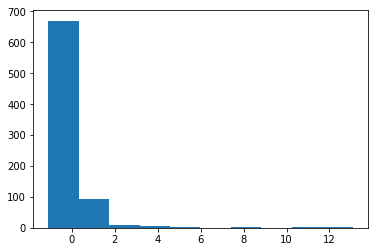

In [8]:
# check if input data are normalized 
plt.hist(x_train[0])

In [9]:
np.std(x_train[:,200])

0.83271211

In [10]:
x_test.shape

(1000, 784)

# Start the coding towards fc ladder network



## Architecture of the network

**Architecture:**

We start with a simple fc NN with an encoder including softmax output and and decoder with same-sized layers as used in the encoder. 

x:h0:784 -> h1:500 -> h2:50 -> h3:10 (softmax) d3':10 -> d2':50' -> d1':500' -> d0':x':784'

**Subarchitecture of a single layer:**

Each layer in the encoder and decoder is composed of different sequential steps as nicely illustrated in Fig1 of  https://arxiv.org/abs/1511.06430.

Within one encoder layer hi (linear trafo, normalization, noise, batch-norm, non-linear-trafo): 

hi_lt -> hi_norm -> hi_noise -> hi_bn -> hi_nlt

within one decoder layer di (combiner, linear-trafo, normalization):

di_comb -> di_lt -> di_norm

**Loss:**

We want to have a supervised loss from label (armax-softmax vs true_label) prediction plus a unsupervised loss from reconstruction of each layer (hi_noise vs di_comb).

In [11]:
##############################################################################
# initialize weight matrices for encoder & decoder: 
# init_weights_v2(layers, layer_level, min_w, max_w, decoder, scope)
# input:
# layers (holding number number of nodes in each layer of the fc NN)
# layer_level (defines the layer from which we start)
# min_w (holds the min value of the random_uniform distribution)
# max_w (holds the min value of the random_uniform distribution)
# decoder (decoder=0 to initialize weights for the encoder, =1 to initialize decoder), scope (for naming)
# scope (for naming)
# output: W (weight matrices for linear trafo), B (offsets in batchnorm)
# only offset Bs are used as offset in batchnorm (no scales in bn since we use ReLu)
##################################################################################
def init_weights_v2(layers, layer_level, min_w, max_w, decoder, scope):
    with tf.variable_scope(scope) as v_scope:
        # shape of W and B needs to be different for encoder or decoder: 
        # if decoder=0 a=layer_level-1 and b=layer_level, if decoder=1, a=layer_level and b=layer_level-1
        a = layer_level - 1*(1-decoder) 
        b = layer_level - 1*decoder
        W = tf.Variable(tf.random_uniform([layers[a], layers[b]], minval=min_w, maxval=max_w), name="weights_lt")  
        B = tf.Variable(tf.zeros(layers[b]), name="offset_bn")
        return W,B



### Set some parameters for the network

In [12]:
# define sizes of layers
L0 = 784  # first layer holds input 
L1 = 500
L2 = 50
L3 = 10   # last layer holds activations before softmax prediction of labels

# layers is a list holding the size of all layers in the fc NN
layers=[L0, L1, L2, L3]

for i in range(len(layers)):
    print("layer {} has size {}".format(i,layers[i]))

layer 0 has size 784
layer 1 has size 500
layer 2 has size 50
layer 3 has size 10


In [13]:
len(layers)

4

In [14]:
# standard deviation for added noise for purly supervised benchmark !!
sd_noise = 0.05  # set as floating number

In [15]:
# set values for weighted sum of reconstruction loss in our 4 layers:
#weights_reconstruction = [100.0, 10.0, 0.1, 0.1]
weights_reconstruction = [0.1, 0.05, 0.01, 0.01]

### Start the graph construction

In [16]:
# reset the default graph

tf.reset_default_graph()

In [17]:
# define placeholder which we need later to feed in our data:
# tf.set_random_seed(1)
## TODO normalize input
x = tf.placeholder(tf.float32, shape=[None, 784], name='x_data')
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_data')

In [18]:
##### Using the customized functions for initialization ######
##############################################################
# initialization of learnable variables 
# predefine intialization of variables which are updated during trianing:
# we use no biases since we do batchnorm (following Martin Görner)
# Bs are used as offset in batchnorm (no scales in bn since we use ReLu)

# learnable variables in encoder, W is for linear transformation (w/o bias), B for batch-norm (w/o scaling) 
# (encoder is selected by setting argument decoder=0):
W1,  B1 = init_weights_v2(layers, layer_level=1, min_w=-0.05, max_w=0.05, decoder=0, scope="var_enc_1")
W2,  B2 = init_weights_v2(layers, layer_level=2, min_w=-0.05, max_w=0.05, decoder=0, scope="var_enc_2")
W3,  B3 = init_weights_v2(layers, layer_level=3, min_w=-0.05, max_w=0.05, decoder=0, scope="var_enc_3")

# learnable variables in decoder:
WD1,  BD1 = init_weights_v2(layers, layer_level=1, min_w=-0.05, max_w=0.05, decoder=1, scope="var_dec_1")
WD2,  BD2 = init_weights_v2(layers, layer_level=2, min_w=-0.05, max_w=0.05, decoder=1, scope="var_dec_2")
WD3,  BD3 = init_weights_v2(layers, layer_level=3, min_w=-0.05, max_w=0.05, decoder=1, scope="var_dec_3")

# learnable variables in vanilla combiner:

## verbose version  for debugging: extract separate matrix columns fo the WC0 and WC1 weights
WC00, WC10, WCsig0, W0z0, W0u0, W0zu0, W0b0, W1z0, W1u0, W1zu0, W1b0 = init_weights_combiner_vanilla(layers[0], 
                                                                                                     scope="var_comb_0",
                                                                                                     verbose=True)
WC01, WC11, WCsig1, W0z1, W0u1, W0zu1, W0b1, W1z1, W1u1, W1zu1, W1b1 = init_weights_combiner_vanilla(layers[1], 
                                                                                                     scope="var_comb_1",
                                                                                                     verbose=True)
WC02, WC12, WCsig2, W0z2, W0u2, W0zu2, W0b2, W1z2, W1u2, W1zu2, W1b2 = init_weights_combiner_vanilla(layers[2], 
                                                                                                     scope="var_comb_2",
                                                                                                     verbose=True)
WC03, WC13, WCsig3, W0z3, W0u3, W0zu3, W0b3, W1z3, W1u3, W1zu3, W1b3 = init_weights_combiner_vanilla(layers[3], 
                                                                                                     scope="var_comb_3",
                                                                                                   verbose=True)
'''
#######################
## test dimensions for init_weights 
## TODO muss neu gemacht werden fuer init_weights_!!!
init_op = tf.global_variables_initializer() 


# run the graph
sess = tf.Session()
sess.run(init_op) #initialization on the concrete realization of the graph

#W3res,WD3res,WC03res, W0u3res = sess.run(fetches=(W3,WD3,WC03, WC0u3)) 

W3res,WD3res,WC03res, W0z3res, W0u3res, W0zu3res, W0b3res,W1z3res, W1u3res, W1zu3res, W1b3res = sess.run(fetches=(W3,WD3,WC03, W0z3, W0u3, W0zu3, W0b3,W1z3, W1u3, W1zu3, W1b3)) 


print(np.shape(W3res))
print(np.shape(WD3res))
print(np.shape(WC03res))

print("WC03res=",WC03res)
print("w0z3=",W0z3res)
print("w0u3=",W0u3res)
print("w0zu3=",W0zu3res)
print("w0b3=",W0b3res)
print("w1z3=",W1z3res)
print("w1u3=",W1u3res)
print("w1zu3=",W1zu3res)
print("w1b3=",W1b3res)

sess.close()

'''

INFO:tensorflow:Summary name var_comb_0/W0z_:0 is illegal; using var_comb_0/W0z__0 instead.
INFO:tensorflow:Summary name var_comb_0/W0u_:0 is illegal; using var_comb_0/W0u__0 instead.
INFO:tensorflow:Summary name var_comb_0/W0zu_:0 is illegal; using var_comb_0/W0zu__0 instead.
INFO:tensorflow:Summary name var_comb_0/W0b_:0 is illegal; using var_comb_0/W0b__0 instead.
INFO:tensorflow:Summary name var_comb_0/W1z_:0 is illegal; using var_comb_0/W1z__0 instead.
INFO:tensorflow:Summary name var_comb_0/W1u_:0 is illegal; using var_comb_0/W1u__0 instead.
INFO:tensorflow:Summary name var_comb_0/W1zu_:0 is illegal; using var_comb_0/W1zu__0 instead.
INFO:tensorflow:Summary name var_comb_0/W1b_:0 is illegal; using var_comb_0/W1b__0 instead.
INFO:tensorflow:Summary name var_comb_1/W0z_:0 is illegal; using var_comb_1/W0z__0 instead.
INFO:tensorflow:Summary name var_comb_1/W0u_:0 is illegal; using var_comb_1/W0u__0 instead.
INFO:tensorflow:Summary name var_comb_1/W0zu_:0 is illegal; using var_comb_1

'\n#######################\n## test dimensions for init_weights \n## TODO muss neu gemacht werden fuer init_weights_!!!\ninit_op = tf.global_variables_initializer() \n\n\n# run the graph\nsess = tf.Session()\nsess.run(init_op) #initialization on the concrete realization of the graph\n\n#W3res,WD3res,WC03res, W0u3res = sess.run(fetches=(W3,WD3,WC03, WC0u3)) \n\nW3res,WD3res,WC03res, W0z3res, W0u3res, W0zu3res, W0b3res,W1z3res, W1u3res, W1zu3res, W1b3res = sess.run(fetches=(W3,WD3,WC03, W0z3, W0u3, W0zu3, W0b3,W1z3, W1u3, W1zu3, W1b3)) \n\n\nprint(np.shape(W3res))\nprint(np.shape(WD3res))\nprint(np.shape(WC03res))\n\nprint("WC03res=",WC03res)\nprint("w0z3=",W0z3res)\nprint("w0u3=",W0u3res)\nprint("w0zu3=",W0zu3res)\nprint("w0b3=",W0b3res)\nprint("w1z3=",W1z3res)\nprint("w1u3=",W1u3res)\nprint("w1zu3=",W1zu3res)\nprint("w1b3=",W1b3res)\n\nsess.close()\n\n'

In [19]:
##### construct clean and noisy encoders  ######

x = my_norm(x, "initial_z_trafo")

#############################################
# clean or noisy encoder construction  - general fcn encoder_prop(h_in, W, B, noise, scope)
# input: h_in: signal from below, W: for the linear trafo, B: offset in bn, noise: None (in clean encoder) or sd_noise-value
# output: hn_lt, hn_norm, hn_noise, hn_bn, hn_nlt
###################################################

#############################################
# noisy encoder construction start
# same weight matrices and biases as in clean encoder
###################################################
# we start with noisy input
xn = my_noise(x, sd_noise, "x_plus_noise")
# in intermediate layer we need in noisy encoder *_noise as lat-input to combiner of decoder
# and *_nlt as input to next layer of the noisy encoder
_, _, hn_1_noise, _, hn_1_nlt = encoder_prop(    x   , W=W1, B=B1, noise=sd_noise, scope="n_encoder_1")
_, _, hn_2_noise, _, hn_2_nlt = encoder_prop(hn_1_nlt, W=W2, B=B2, noise=sd_noise, scope="n_encoder_2")
# in last layer we need *_noise as lat-input to combiner of decoder 
# and *_bn as input to softmax and input to norm for ver-input of combiner
_, _, hn_3_noise, hn_3_bn, _ = encoder_prop(hn_2_nlt, W=W3, B=B3, noise=sd_noise, scope="n_encoder_3")

In [20]:
#############################################
# clean encoder construction start
# same weight matrices and biases as in noisy encoder
###################################################

# in intermediate layer we need in clean encoder *_norm for reconstruction costs 
# and *_nlt as input to next layer
_, h_1_norm, _, _, h_1_nlt = encoder_prop(     x , W=W1, B=B1, noise=None, scope="cl_encoder_1")
_, h_2_norm, _, _, h_2_nlt = encoder_prop(h_1_nlt, W=W2, B=B2, noise=None, scope="cl_encoder_2")
# in last layer we need *_norm for reconstruction costs 
# but *_bn as input to softmax
_, h_3_norm, _, h_3_bn, _ = encoder_prop(h_2_nlt, W=W3, B=B3, noise=None, scope="cl_encoder_3")

In [21]:
'''
#######################
## test dimensions
init_op = tf.global_variables_initializer() 


# run the graph
sess = tf.Session()
sess.run(init_op) #initialization on the concrete realization of the graph
# input: batch of size nb
nb = 4
print(x_train[0:nb].shape)  # (nb, 784)
print(convertToOneHot(y_train[0:nb], 10).shape)  # (nb, 10)
h1res,h2res,h3res,hn1res,hn2res,hn3res = sess.run(fetches=(hn_1_nlt,hn_2_nlt,hn_3_bn,hn_1_noise,hn_2_noise,hn_3_noise), 
                                                  feed_dict={x:x_train[0:nb], y_true:convertToOneHot(y_train[0:nb], 10) }) 

print(np.shape(h1res))
print(np.shape(h2res))
print(np.shape(h3res))
print(np.shape(hn1res))
print(np.shape(hn2res))
print(np.shape(hn3res))

print("output of corrupted encoder, after batch norm but before NL transformation:")
print("hn_3_bn=",h3res)
sess.close()
'''

'\n#######################\n## test dimensions\ninit_op = tf.global_variables_initializer() \n\n\n# run the graph\nsess = tf.Session()\nsess.run(init_op) #initialization on the concrete realization of the graph\n# input: batch of size nb\nnb = 4\nprint(x_train[0:nb].shape)  # (nb, 784)\nprint(convertToOneHot(y_train[0:nb], 10).shape)  # (nb, 10)\nh1res,h2res,h3res,hn1res,hn2res,hn3res = sess.run(fetches=(hn_1_nlt,hn_2_nlt,hn_3_bn,hn_1_noise,hn_2_noise,hn_3_noise), \n                                                  feed_dict={x:x_train[0:nb], y_true:convertToOneHot(y_train[0:nb], 10) }) \n\nprint(np.shape(h1res))\nprint(np.shape(h2res))\nprint(np.shape(h3res))\nprint(np.shape(hn1res))\nprint(np.shape(hn2res))\nprint(np.shape(hn3res))\n\nprint("output of corrupted encoder, after batch norm but before NL transformation:")\nprint("hn_3_bn=",h3res)\nsess.close()\n'

In [22]:
#############################################
# decoder construction  - general fcn decoder_prop(h_lat, h_ver, W0comb, W1comb, wsigcomb, W, B, scope)
# input: for combiner: h_lat, h_ver, W0comb, W1comb, wsigcomb, for linear-trafo: W, B, scope (naming for graf)
# output: d_c (needed in reconstruction cost) , d_lt, d_norm
###################################################

# the lateral input is always the normalized layer with added noise
# the vertical input is the normalized signal from above (in upperst layer the my_norm(*_bn) that was input to softmax)

# in all decoder layer we need the outputs *_c for reconstruction cost
# and *_norm as vertical input in combiner of next lower layer

d_3_c, _, d_3_norm = decoder_prop(h_lat=hn_3_noise, h_ver=my_norm(hn_3_bn, scope="normalize"), 
                       W0comb=WC03, W1comb=WC13, wsigcomb=WCsig3,  W=WD3, B=BD3, scope="decoder_3")

d_2_c, _, d_2_norm = decoder_prop(h_lat=hn_2_noise, h_ver=d_3_norm, 
                        W0comb=WC02, W1comb=WC12, wsigcomb=WCsig2, W=WD2, B=BD2, scope="decoder_2")

d_1_c, _, d_1_norm = decoder_prop(h_lat=hn_1_noise,  h_ver=d_2_norm, 
                        W0comb=WC01, W1comb=WC11, wsigcomb=WCsig1, W=WD1, B=BD1, scope="decoder_1")

# last layer is only a combiner of lateral and horizontal input to get reconstructed image d_0_c
d_0_c = my_comb_vanilla(lateral=xn, vertical=d_1_norm,
                        W0=WC00, W1=WC10, wsig=WCsig0, scope="combiner_0")




In [23]:
'''
#######################
## test dimensions of outcome of decoder_prop

init_op = tf.global_variables_initializer() 

# run the graph
sess = tf.Session()
sess.run(init_op) #initialization on the concrete realization of the graph
#print(x_train[0:2].shape)  # (2, 784)
#print(convertToOneHot(y_train[0:2], 10).shape)  # (2, 10)
# do not use tensor_names (?)
my_x, h1_norm, h2_norm, h3_norm = sess.run(fetches=(x, h_1_norm, h_2_norm, h_3_norm), 
                               feed_dict={x:x_train[0:2], y_true:convertToOneHot(y_train[0:2], 10) }) 

d3_c, d2_c, d1_c, d0_c = sess.run(fetches=(d_3_c, d_2_c, d_1_c, d_0_c), 
                               feed_dict={x:x_train[0:2], y_true:convertToOneHot(y_train[0:2], 10) }) 

hn3_noise, hn2_noise, hn1_noise = sess.run(fetches=(hn_3_noise, hn_2_noise, hn_1_noise), 
                               feed_dict={x:x_train[0:2], y_true:convertToOneHot(y_train[0:2], 10) }) 

hn3_bn, d3_norm = sess.run(fetches=(hn_3_bn, d_3_norm), 
                               feed_dict={x:x_train[0:2], y_true:convertToOneHot(y_train[0:2], 10) }) 

print("shape of my_x:",np.shape(my_x))
print("shape of  h1_norm layer:",np.shape(h1_norm))
print("shape of  h2_norm layer:",np.shape(h2_norm))
print("shape of  h3_norm layer:",np.shape(h3_norm))

print("shape of d0_c layer:",np.shape(d0_c))
print("shape of d1_c layer:",np.shape(d1_c))
print("shape of d2_c layer:",np.shape(d2_c))
print("shape of d3_c layer:",np.shape(d3_c))

print("shape of  hn3_bn layer:",np.shape(hn3_bn))
print("shape of  d3_norm:",np.shape(d3_norm))

print("output of vanilla combiner:")
print("d_0_c = ",d0_c)
sess.close()

'''

'\n#######################\n## test dimensions of outcome of decoder_prop\n\ninit_op = tf.global_variables_initializer() \n\n# run the graph\nsess = tf.Session()\nsess.run(init_op) #initialization on the concrete realization of the graph\n#print(x_train[0:2].shape)  # (2, 784)\n#print(convertToOneHot(y_train[0:2], 10).shape)  # (2, 10)\n# do not use tensor_names (?)\nmy_x, h1_norm, h2_norm, h3_norm = sess.run(fetches=(x, h_1_norm, h_2_norm, h_3_norm), \n                               feed_dict={x:x_train[0:2], y_true:convertToOneHot(y_train[0:2], 10) }) \n\nd3_c, d2_c, d1_c, d0_c = sess.run(fetches=(d_3_c, d_2_c, d_1_c, d_0_c), \n                               feed_dict={x:x_train[0:2], y_true:convertToOneHot(y_train[0:2], 10) }) \n\nhn3_noise, hn2_noise, hn1_noise = sess.run(fetches=(hn_3_noise, hn_2_noise, hn_1_noise), \n                               feed_dict={x:x_train[0:2], y_true:convertToOneHot(y_train[0:2], 10) }) \n\nhn3_bn, d3_norm = sess.run(fetches=(hn_3_bn, d_3_norm), \n 

In [24]:
## DEBUG: TRY DECODER WITH ONLY VERTICAL INPUT 
## SET LOSS TO UNSUPERVISED ONLY AND ONLY FINAL RECONSTRUCTION
## ==> NO LEARNING. TRAINING LOSS FLUCTUATES SLIGHTLY, VALIDATION LOSS EVEN LESS...
'''
d_3_c, _, d_3_norm = decoder_prop_ver( h_ver=my_norm(hn_3_bn, scope="normalize"), W=WD3, B=BD3, scope="decoder_3")

d_2_c, _, d_2_norm = decoder_prop_ver(h_ver=d_3_norm, W=WD2, B=BD2, scope="decoder_2")

d_1_c, _, d_1_norm = decoder_prop_ver(h_ver=d_2_norm, W=WD1, B=BD1, scope="decoder_1")

# reconstructed image d_0_c
d_0_c = d_1_norm
          

## TEST
init_op = tf.global_variables_initializer() 
# run the graph
sess = tf.Session()
sess.run(init_op) #initialization on the concrete realization of the graph
#print(x_train[0:2].shape)  # (2, 784)
#print(convertToOneHot(y_train[0:2], 10).shape)  # (2, 10)
# do not use tensor_names (?)
my_x, h1_norm, h2_norm, h3_norm = sess.run(fetches=(x, h_1_norm, h_2_norm, h_3_norm), 
                               feed_dict={x:x_train[0:2], y_true:convertToOneHot(y_train[0:2], 10) }) 

d3_c, d2_c, d1_c, d0_c = sess.run(fetches=(d_3_c, d_2_c, d_1_c, d_0_c), 
                               feed_dict={x:x_train[0:2], y_true:convertToOneHot(y_train[0:2], 10) }) 

hn3_noise, hn2_noise, hn1_noise = sess.run(fetches=(hn_3_noise, hn_2_noise, hn_1_noise), 
                               feed_dict={x:x_train[0:2], y_true:convertToOneHot(y_train[0:2], 10) }) 

hn3_bn, d3_norm = sess.run(fetches=(hn_3_bn, d_3_norm), 
                               feed_dict={x:x_train[0:2], y_true:convertToOneHot(y_train[0:2], 10) }) 

print("shape of my_x:",np.shape(my_x))
print("shape of  h1_norm layer:",np.shape(h1_norm))
print("shape of  h2_norm layer:",np.shape(h2_norm))
print("shape of  h3_norm layer:",np.shape(h3_norm))

print("shape of d0_c layer:",np.shape(d0_c))
print("shape of d1_c layer:",np.shape(d1_c))
print("shape of d2_c layer:",np.shape(d2_c))
print("shape of d3_c layer:",np.shape(d3_c))

print("shape of  hn3_bn layer:",np.shape(hn3_bn))
print("shape of  d3_norm:",np.shape(d3_norm))

print("d_0_c = ",d0_c)
sess.close()
'''

'\nd_3_c, _, d_3_norm = decoder_prop_ver( h_ver=my_norm(hn_3_bn, scope="normalize"), W=WD3, B=BD3, scope="decoder_3")\n\nd_2_c, _, d_2_norm = decoder_prop_ver(h_ver=d_3_norm, W=WD2, B=BD2, scope="decoder_2")\n\nd_1_c, _, d_1_norm = decoder_prop_ver(h_ver=d_2_norm, W=WD1, B=BD1, scope="decoder_1")\n\n# reconstructed image d_0_c\nd_0_c = d_1_norm\n          \n\n## TEST\ninit_op = tf.global_variables_initializer() \n# run the graph\nsess = tf.Session()\nsess.run(init_op) #initialization on the concrete realization of the graph\n#print(x_train[0:2].shape)  # (2, 784)\n#print(convertToOneHot(y_train[0:2], 10).shape)  # (2, 10)\n# do not use tensor_names (?)\nmy_x, h1_norm, h2_norm, h3_norm = sess.run(fetches=(x, h_1_norm, h_2_norm, h_3_norm), \n                               feed_dict={x:x_train[0:2], y_true:convertToOneHot(y_train[0:2], 10) }) \n\nd3_c, d2_c, d1_c, d0_c = sess.run(fetches=(d_3_c, d_2_c, d_1_c, d_0_c), \n                               feed_dict={x:x_train[0:2], y_true:conve

In [25]:
########################################################################
# loss has several parts for supervised and unsupervised (reconstruction ) task
############################################################################

# cross-entropy loss function (= -sum(Y_i * log(Yi)) ), 
# TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
# problems with log(0) which is NaN

with tf.name_scope("loss_supervised"):
    out = tf.nn.softmax(hn_3_bn)  # TODO : IS THIS ERROR PRONE? 
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=hn_3_bn, labels=y_true)
    # loss from supervised learning:
    loss_supervised = tf.reduce_mean(cross_entropy) 

with tf.name_scope("accuracy"):
    which_y_true = tf.argmax(y_true, 1)
    which_y_pred = tf.argmax(tf.nn.softmax(hn_3_bn), 1)
    correct_prediction = tf.equal(which_y_true, which_y_pred)  # no of correct predictions
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) 

In [26]:
reconst_loss(encoder_clean=x, decoder=d_0_c, scope="dist_0")

<tf.Tensor 'squared_dist/Mean:0' shape=() dtype=float32>

In [27]:
# loss unsupervised per layer  - by fcn reconst_loss(encoder_clean, decoder, scope):
# input: encoder_clean, decoder (same shape than encoder_clean), scope
# output: loss_reconst (squared Euclidean distance between clean encoder layer and corresponding decoder layer)

with tf.name_scope("loss_reconstruction"):
    loss_us_layer_0 = reconst_loss(encoder_clean=x, decoder=d_0_c, scope="dist_0")
    loss_us_layer_1 = reconst_loss(encoder_clean=h_1_norm, decoder=d_1_c, scope="dist_1")
    loss_us_layer_2 = reconst_loss(encoder_clean=h_2_norm, decoder=d_2_c, scope="dist_2")
    loss_us_layer_3 = reconst_loss(encoder_clean=h_3_norm, decoder=d_3_c, scope="dist_3")
        
    with tf.name_scope("add_all_dist"):
        loss_unsupervised = weights_reconstruction[0]*loss_us_layer_0  + weights_reconstruction[1]*loss_us_layer_1  + weights_reconstruction[2]*loss_us_layer_2    + weights_reconstruction[3]*loss_us_layer_3   
        #loss_unsupervised = weights_reconstruction[0]*loss_us_layer_0
    

In [28]:
'''
#######################
## test unsupervised loss calculation

init_op = tf.global_variables_initializer() 

# run the graph
nb = 2
sess = tf.Session()
sess.run(init_op) #initialization on the concrete realization of the graph

d3_c, d2_c, d1_c, d0_c, h1_norm, h2_norm = sess.run(fetches=(d_3_c, d_2_c, d_1_c, d_0_c,  h_1_norm, h_2_norm), 
                               feed_dict={x:x_train[0:nb], y_true:convertToOneHot(y_train[0:nb], 10) }) 
my_x,my_loss_us0,my_loss_us1,my_loss_us2,my_loss_us3,loss_us_tot =  sess.run(fetches=(x,loss_us_layer_0,loss_us_layer_1,loss_us_layer_2,loss_us_layer_3,loss_unsupervised), 
                               feed_dict={x:x_train[0:nb], y_true:convertToOneHot(y_train[0:nb], 10)  }) 



print("output of vanilla combiner:")
print("d_0_c = ",d0_c)
print("shape of  x:",np.shape(my_x))
print("shape of  d0_c:",np.shape(d0_c))
#print("shape of  loss_us0:",np.shape(my_loss_us0))
#print("shape of  loss_us1:",np.shape(my_loss_us1))
print("loss_us0=",my_loss_us0)
print("loss_us1=",my_loss_us1)
print("loss_us2=",my_loss_us2)
print("loss_us3=",my_loss_us3)
print("loss_us_tot=",loss_us_tot)
print("w_reconst=",weights_reconstruction[3]*my_loss_us3)


sess.close()
'''

'\n#######################\n## test unsupervised loss calculation\n\ninit_op = tf.global_variables_initializer() \n\n# run the graph\nnb = 2\nsess = tf.Session()\nsess.run(init_op) #initialization on the concrete realization of the graph\n\nd3_c, d2_c, d1_c, d0_c, h1_norm, h2_norm = sess.run(fetches=(d_3_c, d_2_c, d_1_c, d_0_c,  h_1_norm, h_2_norm), \n                               feed_dict={x:x_train[0:nb], y_true:convertToOneHot(y_train[0:nb], 10) }) \nmy_x,my_loss_us0,my_loss_us1,my_loss_us2,my_loss_us3,loss_us_tot =  sess.run(fetches=(x,loss_us_layer_0,loss_us_layer_1,loss_us_layer_2,loss_us_layer_3,loss_unsupervised), \n                               feed_dict={x:x_train[0:nb], y_true:convertToOneHot(y_train[0:nb], 10)  }) \n\n\n\nprint("output of vanilla combiner:")\nprint("d_0_c = ",d0_c)\nprint("shape of  x:",np.shape(my_x))\nprint("shape of  d0_c:",np.shape(d0_c))\n#print("shape of  loss_us0:",np.shape(my_loss_us0))\n#print("shape of  loss_us1:",np.shape(my_loss_us1))\nprint(

In [29]:
with tf.name_scope("loss_both"):    
    loss_both = loss_supervised + loss_unsupervised 
    #loss_both = loss_unsupervised 

In [30]:
with tf.name_scope("initialize"):
    init_op = tf.global_variables_initializer() 

In [31]:
# for nicer graph withou Optimizer in graph
# Optimizer
with tf.name_scope("train_step"):
    train_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss_both)

### Execute the graph and do some training¶

In [32]:
#We want to visualize the development of the following variables in tensorboard:
for v in tf.trainable_variables():
    print("Adding ", v.name)
    tf.summary.histogram(v.name, v)

Adding  var_enc_1/weights_lt:0
INFO:tensorflow:Summary name var_enc_1/weights_lt:0 is illegal; using var_enc_1/weights_lt_0 instead.
Adding  var_enc_1/offset_bn:0
INFO:tensorflow:Summary name var_enc_1/offset_bn:0 is illegal; using var_enc_1/offset_bn_0 instead.
Adding  var_enc_2/weights_lt:0
INFO:tensorflow:Summary name var_enc_2/weights_lt:0 is illegal; using var_enc_2/weights_lt_0 instead.
Adding  var_enc_2/offset_bn:0
INFO:tensorflow:Summary name var_enc_2/offset_bn:0 is illegal; using var_enc_2/offset_bn_0 instead.
Adding  var_enc_3/weights_lt:0
INFO:tensorflow:Summary name var_enc_3/weights_lt:0 is illegal; using var_enc_3/weights_lt_0 instead.
Adding  var_enc_3/offset_bn:0
INFO:tensorflow:Summary name var_enc_3/offset_bn:0 is illegal; using var_enc_3/offset_bn_0 instead.
Adding  var_dec_1/weights_lt:0
INFO:tensorflow:Summary name var_dec_1/weights_lt:0 is illegal; using var_dec_1/weights_lt_0 instead.
Adding  var_dec_1/offset_bn:0
INFO:tensorflow:Summary name var_dec_1/offset_bn

In [33]:
# We want to visualize the development of losses in tensorboard

#loss_both = loss_supervised + loss_unsupervised 
tf.summary.scalar("loss_both", loss_both)
tf.summary.scalar("loss_supervised", loss_supervised)
tf.summary.scalar("loss_unsupervised", loss_unsupervised)
tf.summary.scalar("loss_us_layer_0", loss_us_layer_0)
tf.summary.scalar("loss_us_layer_1", loss_us_layer_1)
tf.summary.scalar("loss_us_layer_2", loss_us_layer_2)
tf.summary.scalar("loss_us_layer_3", loss_us_layer_3)

<tf.Tensor 'loss_us_layer_3:0' shape=() dtype=string>

In [34]:
! rm -rf /tmp/ladder

In [35]:
! mkdir /tmp/ladder

In [36]:

! ls /tmp/ladder

In [37]:
# collect all summaries for tensorboard and define the directory for saved summary files 

merged_summary_op = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter("/tmp/ladder", tf.get_default_graph())

In [38]:
sess = tf.Session() 
sess.run(init_op)

In [39]:
# check the shape of the feeds:
#x = tf.placeholder(tf.float32, shape=[None, 784], name='x_data')
#y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_data')
print("x_train.shape:", x_train.shape)  # (2, 784)
print("convertToOneHot(y_train, 10).shape:", convertToOneHot(y_train, 10).shape)  # (2, 10)

x_train.shape: (3000, 784)
convertToOneHot(y_train, 10).shape: (3000, 10)


In [40]:
vals = []
for i in range(1000):#10000
    idx = np.random.permutation(len(x_train))[0:128] #Easy minibatch of size 128
    loss_, _, res_ = sess.run((loss_both, train_op, out), 
                              feed_dict={x:x_train[idx], y_true:convertToOneHot(y_train[idx], 10)})
    if (i % 100 == 0):#50
        acc = np.average(np.argmax(res_, axis = 1) == y_train[idx])
        # Get the results for the validation results 
        loss_v, res_val, summary_ = sess.run([loss_both, out, merged_summary_op], 
                                                          feed_dict={x:x_test, y_true:convertToOneHot(y_test, 10)})
        summary_writer.add_summary(summary_, i)
        acc_v = np.average(np.argmax(res_val, axis = 1) == y_test)
        vals.append([loss_, acc, loss_v, acc_v])
        print("{} Training: loss {} acc {} Validation: loss {} acc {}".format(i, loss_, acc, loss_v, acc_v))
        

0 Training: loss 834.8570556640625 acc 0.0703125 Validation: loss 268.86297607421875 acc 0.156
100 Training: loss 11.358426094055176 acc 0.921875 Validation: loss 8.048396110534668 acc 0.871
200 Training: loss 10.506567001342773 acc 0.921875 Validation: loss 7.057535171508789 acc 0.892
300 Training: loss 8.553781509399414 acc 0.9765625 Validation: loss 6.212344646453857 acc 0.904
400 Training: loss 7.521876335144043 acc 0.984375 Validation: loss 5.530648231506348 acc 0.902
500 Training: loss 7.448641777038574 acc 1.0 Validation: loss 4.886605262756348 acc 0.904
600 Training: loss 5.740861892700195 acc 1.0 Validation: loss 4.365663051605225 acc 0.915
700 Training: loss 5.160611152648926 acc 0.984375 Validation: loss 3.8913216590881348 acc 0.915
800 Training: loss 5.78906774520874 acc 0.9921875 Validation: loss 3.493112802505493 acc 0.913
900 Training: loss 5.884727478027344 acc 1.0 Validation: loss 3.127711534500122 acc 0.911


In [ ]:
## TODO check development of weights
## todo check if supervised and unsupervised loss should get the same weight in loss_both
## TODO: use moving average for mean and sd values in batch-normalization (understand code Martin Görner: bn-goerner.ipynb)
## use proposed "best hyper-paramenters" from supplementary material
### TODO do real semi-supervised learning (each batch consists of n1 labeled and n2 unlabeled data)
# check the performance of the fc ladder with 100 labeled and 50000 unlabeled data
## TODO : in test modus we should use clean encoder for prediction
## Todo: check learning rate development
## TODO: try multiplicative noise and dropout in test modus with MAP as point estimator and credibility intervals


In [ ]:
# compare to directory in tf.summary.FileWriter
! tensorboard --logdir /tmp/ladder/
# check docker call and go to http://srv-lab-t-697:8711